In [1]:
import anndata as ad
import scanpy as sc
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import polars as pl
import mudata
import os
import gseapy
import muon as mu
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
mudata.set_options(pull_on_update=False)
import bbknn
import scvi

/localenv/deboutte/anaconda/miniconda/envs/linkapy/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/localenv/deboutte/anaconda/miniconda/envs/linkapy/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/localenv/deboutte/anaconda/miniconda/envs/linkapy/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/localenv/deboutte/anaconda/miniconda/envs/linkapy/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarnin

# Germ layers

In [2]:
germ_layer_markers = {}
with open('external_data/embryonic_layer_markers2.txt', 'r') as f:
    for line in f:
        _l = line.strip().split(',')
        _ll = _l[0]
        _m = _l[1::]
        germ_layer_markers[_ll] = _m

# Regions scNMT

In [3]:
adata = mudata.read_h5mu("mudata/gastro/scNMT.h5mu")
with open('external_data/scNMT_regions.bed', 'w') as f:
    for i,r in adata['ACC'].var[adata['ACC'].var['class'].isin(['promoters', 'enhancers'])].iterrows():
        f.write(f"{str(r['chrom'])}\t{int(float(r['start']))}\t{int(float(r['end']))}\n")

# Public dataset

In [4]:
if not os.path.exists('mudata/public_scATAC/scatac.h5ad'):
    _rows = pd.read_csv("external_data/mouse_embryo_cells.csv", header=0)
    _cols = pd.read_csv("external_data/mouse_embryo_regions.csv", header=0)
    matrix = sp.io.mmread("external_data/mouse_embryo.mtx").tocsr().transpose()
    adata = ad.AnnData(X=matrix)
    adata.obs = _rows
    adata.var = _cols
    adata.obs['cell_type'] = [i.split('_')[1] for i in adata.obs['cell_id']]
    adata.obs['timepoint'] = [i.split('#')[0].split('_')[-2] + '.' + i.split('#')[0].split('_')[-1] for i in adata.obs['cell_id']]
    adata.obs['cell_type'].unique()
    adata = adata[np.array(adata.obs['timepoint'] == 'E7.5'),].copy()
    adata.write("mudata/public_scATAC/scatac.h5ad")

In [5]:
scatac = ad.io.read_h5ad('mudata/public_scATAC/scatac.h5ad')
if not os.path.exists('external_data/mouse_embryo_regions.bed'):
    with open('external_data/mouse_embryo_regions.bed', 'w') as f:
        for i,r in scatac.var.iterrows():
            _r = r['gene_id'].split('_')
            f.write(f"{str(_r[0])}\t{int(float(_r[1]))}\t{int(float(_r[2]))}\n")

# The bed file with mouse peaks intersected with promoters needs to be present.
# Subset the scatac part.
_intersected_peaks = []
with open('external_data/mouse_embryo_regions_intersect.bed', 'r') as f:
    for line in f:
        _l = line.strip().split('\t')
        _intersected_peaks.append(
            f"{_l[0]}_{_l[1]}_{_l[2]}"
        )

# Gastro

In [6]:
adata = mudata.read_h5mu("mudata/gastro/scNMT.h5mu")

In [7]:
mudat = mudata.MuData(
    {
        'ACC': adata['ACC'][: ,np.array(adata['ACC'].var['class'].isin(['promoters', 'enhancers']))].copy(),
        'METH': adata['METH'][: ,np.array(adata['METH'].var['class'].isin(['promoters', 'enhancers']))].copy(),
        'RNA':  adata['RNA'].copy()
    }
)
mudat['ACC'].var['gene'] = mudat['ACC'].var.index
mudat['METH'].var['gene'] = mudat['METH'].var.index

# Get one-to-one mapping

In [8]:
mers = {}
scmers = {}
with open('external_data/mouse_embryo_regions_intersect.bed') as f:
    for line in f:
        _l = line.strip().split('\t')
        if _l[0] not in mers:
            mers[_l[0]] = [f"{_l[0]}_{_l[1]}_{_l[2]}"]
        else:
            mers[_l[0]].append(f"{_l[0]}_{_l[1]}_{_l[2]}")
with open('external_data/scNMT_regions.bed') as f:
    for line in f:
        _l = line.strip().split('\t')
        if _l[0] != 'chrM' and _l[0] != 'chrY':
            if _l[0] not in scmers:
                scmers[_l[0]] = [f"{_l[0]}_{_l[1]}_{_l[2]}"]
            else:
                scmers[_l[0]].append(f"{_l[0]}_{_l[1]}_{_l[2]}")

assert mers.keys() == scmers.keys()
scnmt_to_atacpeaks = {}
prix = 0
for chrom in mers:
    for i in mers[chrom]:
        for j in scmers[chrom]:
            start1 = int(i.split('_')[1])
            end1 = int(i.split('_')[2])
            start2 = int(j.split('_')[1])
            end2 = int(j.split('_')[2])
            overlap = max(0, min(end1, end2) - max(start1, start2))
            if overlap > 0:
                if i in scnmt_to_atacpeaks:
                    if scnmt_to_atacpeaks[i][1] < overlap:
                        scnmt_to_atacpeaks[i] = [j, overlap]
                else:
                    scnmt_to_atacpeaks[i] = [j, overlap]
    prix += 1
    print(f"Processed = {prix} / {len(mers)} chroms")

Processed = 1 / 20 chroms
Processed = 2 / 20 chroms
Processed = 3 / 20 chroms
Processed = 4 / 20 chroms
Processed = 5 / 20 chroms
Processed = 6 / 20 chroms
Processed = 7 / 20 chroms
Processed = 8 / 20 chroms
Processed = 9 / 20 chroms
Processed = 10 / 20 chroms
Processed = 11 / 20 chroms
Processed = 12 / 20 chroms
Processed = 13 / 20 chroms
Processed = 14 / 20 chroms
Processed = 15 / 20 chroms
Processed = 16 / 20 chroms
Processed = 17 / 20 chroms
Processed = 18 / 20 chroms
Processed = 19 / 20 chroms
Processed = 20 / 20 chroms


In [9]:
_scnmt_roi = [scnmt_to_atacpeaks[i][0] for i in scnmt_to_atacpeaks]
peakn = []
for i,r in adata['ACC'].var.iterrows():
    peakn.append(f"{r['chrom']}_{r['start']}_{r['end']}")
adata['ACC'].var['peakn'] = peakn
adata['METH'].var['peakn'] = peakn
mudat = mudata.MuData(
    {
        'ACC': adata['ACC'][: ,np.array(adata['ACC'].var['peakn'].isin(_scnmt_roi))].copy(),
        'METH': adata['METH'][: ,np.array(adata['METH'].var['peakn'].isin(_scnmt_roi))].copy(),
        'RNA':  adata['RNA'].copy()
    }
)
mudat['ACC'].var['gene'] = mudat['ACC'].var.index
mudat['METH'].var['gene'] = mudat['METH'].var.index

In [10]:
scatac = ad.io.read_h5ad('mudata/public_scATAC/scatac.h5ad')
scatac = scatac[:,np.array(scatac.var['gene_id'].isin(scnmt_to_atacpeaks.keys()))].copy()
scatac.var.columns = ['peakname']
_annotation = pd.read_table('external_data/uropa/mouse_embryo_regions_annotation_finalhits.txt')
_annotation['peakname'] = _annotation["peak_chr"] + "_" + _annotation["peak_start"].astype(str) + "_" + _annotation["peak_end"].astype(str)
scatac.var = pd.merge(scatac.var, _annotation[['relative_location', 'gene_name', 'peakname']], left_on='peakname', right_on='peakname', how='left')

X_bin = (scatac.X > 0).astype(int)
X_log = X_bin.multiply(1e4 / X_bin.sum(axis=1))
X_log.data = np.log1p(X_log.data)
svd = TruncatedSVD(n_components=50, random_state=0)
scatac.obsm["X_lsi"] = svd.fit_transform(X_log)
sc.pp.neighbors(scatac, use_rep="X_lsi", n_neighbors=20)
sc.tl.umap(scatac)
sc.tl.leiden(scatac, resolution=0.5)

/tmp/ipykernel_115558/1030921756.py:15: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(scatac, resolution=0.5)


/tmp/ipykernel_115558/2919987818.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_atacsig = scatac.to_df().groupby(scatac.obs['leiden']).mean()


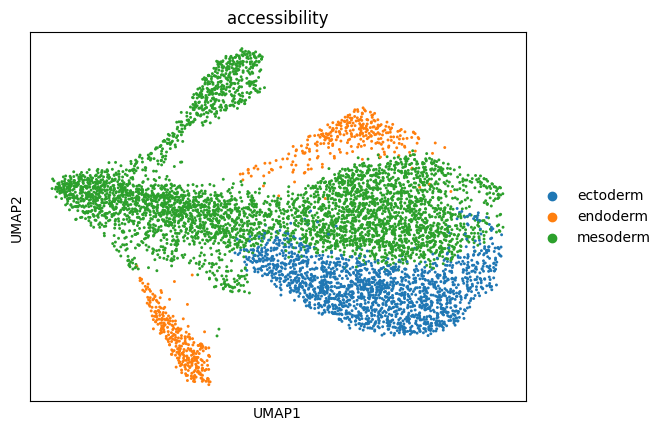

In [11]:
cluster_atacsig = scatac.to_df().groupby(scatac.obs['leiden']).mean()
cluster_atacsig

dfs = []
for celltype, markers in germ_layer_markers.items():
    dfs.append(cluster_atacsig.iloc[:, scatac.var[(scatac.var['gene_name'].isin(markers))].index].mean(axis=1))

layerscores = pd.concat(dfs, axis=1)
layerscores.columns = germ_layer_markers.keys()
layerscores = layerscores.idxmax(axis=1).to_dict()
layerscores
scatac.obs['cell type - scATAC'] = scatac.obs['leiden'].map(layerscores)
sc.pl.umap(scatac, color='cell type - scATAC', title='accessibility', save='gastr_acc_scatac_umap_layers.png')

# scNMT part

In [12]:
adata = mudata.read_h5mu("mudata/gastro/scNMT.h5mu")
adata.obs['timepoint'] = [i.split('_')[0] for i in adata.obs.index]
mudat = adata[adata.obs[adata.obs['timepoint'] == 'E7.5'].index]
mudat = mudata.MuData(
    {
        'ACC': mudat['ACC'][: ,np.array(mudat['ACC'].var['class'].isin(['promoters', 'enhancers']))].copy(),
        'METH': mudat['METH'][: ,np.array(mudat['METH'].var['class'].isin(['promoters', 'enhancers']))].copy(),
        'RNA':  mudat['RNA'].copy()
    }
)
mudat['ACC'].var['gene'] = mudat['ACC'].var.index
mudat['METH'].var['gene'] = mudat['METH'].var.index
mudat['ACC'].var['peakname'] = mudat['ACC'].var['chrom'].astype(str) + '_' + mudat['ACC'].var['start'].astype(str) + '_' + mudat['ACC'].var['end'].astype(str)
mudat['METH'].var['peakname'] = mudat['METH'].var['chrom'].astype(str) + '_' + mudat['METH'].var['start'].astype(str) + '_' + mudat['METH'].var['end'].astype(str)

In [13]:
_acc = mudat['ACC']
_annotation = pd.read_table('external_data/uropa/scNMT_regions_annotation_finalhits.txt')
_annotation['peakname'] = _annotation["peak_chr"] + "_" + _annotation["peak_start"].astype(str) + "_" + _annotation["peak_end"].astype(str)
_annotation = _annotation[['relative_location', 'gene_name', 'peakname']].drop_duplicates(subset='peakname', keep='first')
_acc.var = pd.merge(_acc.var, _annotation[['relative_location', 'gene_name', 'peakname']], left_on='peakname', right_on='peakname', how='left')
mudat['METH'].var = pd.merge(_acc.var, _annotation[['relative_location', 'gene_name', 'peakname']], left_on='peakname', right_on='peakname', how='left')

In [14]:
acc2gene = {}
with open('external_data/acc2name.txt') as f:
    for line in f:
        acc2gene[line.strip().split('\t')[0]] = line.strip().split('\t')[1]
mudat['RNA'].var['gene_name'] = mudat['RNA'].var.index.map(acc2gene)

In [15]:
X_bin = (mudat['ACC'].X > 0).astype(int)
nonzero_mask = X_bin.sum(axis=1) != 0
X_bin_filtered = X_bin[nonzero_mask]
mudat['ACC']._inplace_subset_obs(nonzero_mask)
mudat['METH']._inplace_subset_obs(nonzero_mask)
mudat['RNA']._inplace_subset_obs(nonzero_mask)
# X_log = X_bin_filtered * (1e4 / X_bin_filtered.sum(axis=1, keepdims=True))
# X_log.data = np.log1p(X_log.data)
X_log = sp.sparse.csr_matrix(X_bin_filtered * (1e4 / X_bin_filtered.sum(axis=1, keepdims=True)))
X_log.data = np.log1p(X_log.data)
svd = TruncatedSVD(n_components=50, random_state=0)
mudat['ACC'].obsm["X_lsi"] = svd.fit_transform(X_log)
sc.pp.neighbors(mudat['ACC'], use_rep="X_lsi", n_neighbors=20)
sc.tl.umap(mudat['ACC'])
sc.tl.leiden(mudat['ACC'], resolution=0.6)

/localenv/deboutte/anaconda/miniconda/envs/linkapy/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/localenv/deboutte/anaconda/miniconda/envs/linkapy/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/tmp/ipykernel_115558/525171074.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_accsig = mudat['ACC'].to_df().groupby(mudat['ACC'].obs['leiden']).mean()


['Foxa2', 'Gata4', 'Cxcr4', 'Hhex', 'Eomes', 'Gata6']
['Pax6', 'Sox1', 'Sox2', 'Zic1', 'Zic2', 'Otx2', 'Hes3']
['T', 'Mesp1', 'Hand1', 'Hand2']


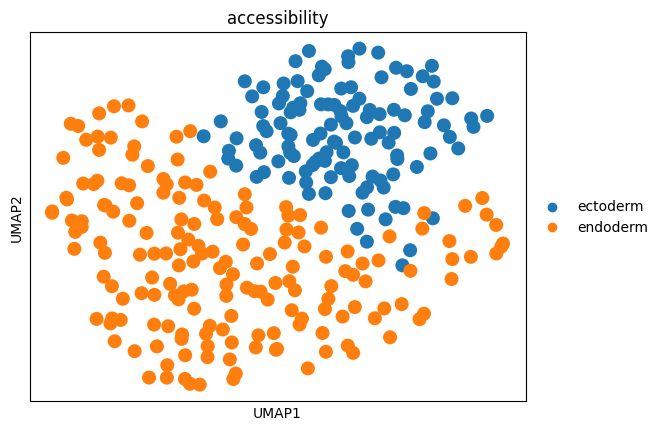

In [16]:
cluster_accsig = mudat['ACC'].to_df().groupby(mudat['ACC'].obs['leiden']).mean()
cluster_accsig.columns = mudat['ACC'].var['gene_name']


dfs = []
for celltype, markers in germ_layer_markers.items():
    fms = [i for i in markers if i in cluster_accsig.columns]
    print(fms)
    dfs.append(cluster_accsig[fms].mean(axis=1).fillna(0.0))

layerscores = pd.concat(dfs, axis=1)
layerscores

layerscores.columns = germ_layer_markers.keys()
layerscores = layerscores.idxmin(axis=1).to_dict()
mudat['ACC'].obs['celltype'] = mudat['ACC'].obs['leiden'].map(layerscores)
#mudat['METH'].obs['celltype'] = mudat['METH'].obs.index.map(layerscores)
sc.pl.umap(mudat['ACC'], color='celltype', title='accessibility', save='gastr_acc_scnmt_umap_layers.png')

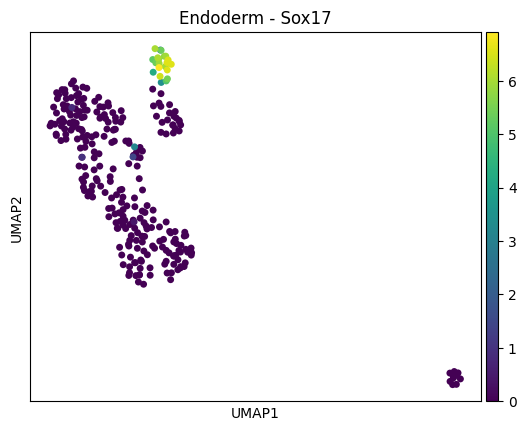

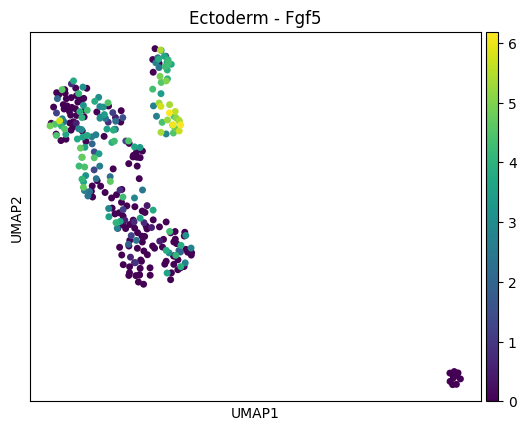

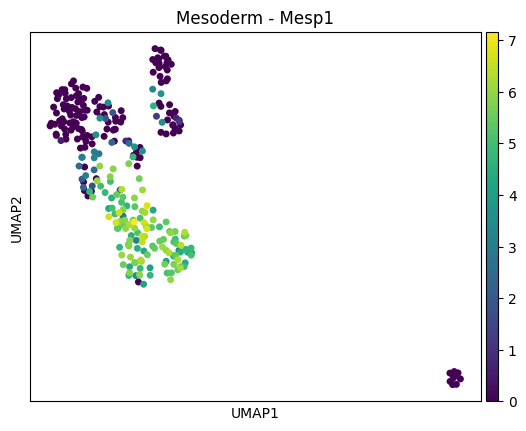

In [17]:
_rna = mudat['RNA'].copy()
sc.pp.normalize_total(_rna)
sc.pp.log1p(_rna)
sc.pp.highly_variable_genes(_rna, n_top_genes=1000)
sc.pp.pca(_rna)
sc.pp.neighbors(_rna, n_neighbors=15, n_pcs=25)
sc.tl.leiden(_rna, resolution=0.25)
sc.tl.umap(_rna)
_rna.obs['transcription'] = _rna.obs['leiden']
sc.pl.umap(_rna, color=_rna.var[_rna.var['gene_name'] == 'Sox17'].index[0], size=100, title='Endoderm - Sox17', save='gastr_rna_scnmt_endoderm.png')
sc.pl.umap(_rna, color=_rna.var[_rna.var['gene_name'] == 'Fgf5'].index[0], size=100, title='Ectoderm - Fgf5', save='gastr_rna_scnmt_ectoderm.png')
sc.pl.umap(_rna, color=_rna.var[_rna.var['gene_name'] == 'Mesp1'].index[0], size=100, title='Mesoderm - Mesp1', save='gastr_rna_scnmt_mesoderm.png')

In [18]:
cdic = {}
for _c in _rna.obs.index:
    cdic[_c] = ['nan']

for i in _rna.obs.loc[_rna[:, _rna.var['gene_name'] == 'Sox17'].X.toarray().flatten() > 3,].index:
    cdic[i] = ['Endoderm']
for i in _rna.obs.loc[_rna[:, _rna.var['gene_name'] == 'Fgf5'].X.toarray().flatten() > 3,].index:
    cdic[i] = ['Ectoderm']
for i in _rna.obs.loc[_rna[:, _rna.var['gene_name'] == 'Mesp1'].X.toarray().flatten() > 3,].index:
    cdic[i] = ['Mesoderm']
andf = pd.DataFrame(cdic).T
andf.columns = ['celltype']
andf.to_csv('output/scnmt_annotation.csv')

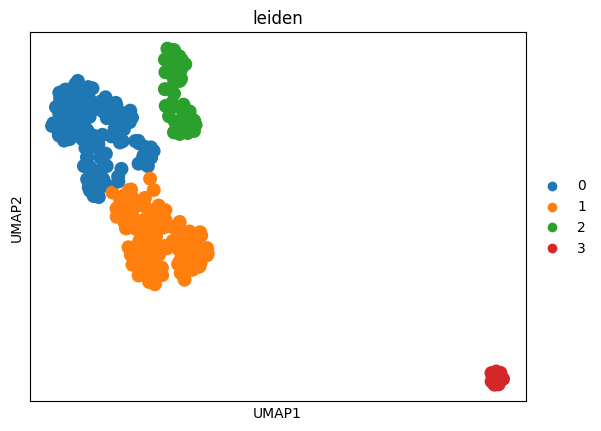

In [21]:
sc.pl.umap(_rna, color='leiden')

In [27]:
# Get some information on the 'weird' cluster
sc.tl.rank_genes_groups(_rna, "leiden", method="wilcoxon")
gr3 = sc.get.rank_genes_groups_df(_rna, group="3", key="rank_genes_groups")
gr3_res = pd.merge(gr3, _rna.var, left_on='names', right_index=True, how='left')
gr3_res[gr3_res['pvals'] < 0.05]

,names,scores,logfoldchanges,pvals,pvals_adj,Chr,Start,End,Strand,Length,gene_name,highly_variable,means,dispersions,dispersions_norm
43155,ENSMUSG00000112748.1,-1.961495,-28.540600,4.982134e-02,0.225392,chr10,71162928,71163377,+,450,Gm6331,False,0.469407,0.718878,-2.175619
43156,ENSMUSG00000114940.1,-1.961495,-28.565180,4.982134e-02,0.225392,chr13,120099087,120100332,-,1246,Gm21378,False,0.527614,1.368905,-1.639716
43157,ENSMUSG00000036339.18,-1.961495,-30.220707,4.982134e-02,0.225392,chr14,48446124,48524246,+,78123,Tmem260,False,2.204791,4.384119,0.478073
43158,ENSMUSG00000030513.14,-1.961495,-29.319710,4.982134e-02,0.225392,chr7,65861734,66050386,+,188653,Pcsk6,False,1.373595,3.621392,-0.185518
43159,ENSMUSG00000057329.7,-1.961495,-29.360714,4.982134e-02,0.225392,chr1,106538178,106714274,-,176097,Bcl2,False,1.331648,3.302798,-0.294824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55396,ENSMUSG00000029673.17,-5.626914,-36.009930,1.834620e-08,0.000001,chr5,131437333,132543344,-,1106012,Auts2,False,5.042650,7.054097,1.270202
55397,ENSMUSG00000020745.15,-5.626914,-36.653263,1.834620e-08,0.000001,chr11,74673949,74724670,-,50722,Pafah1b1,False,4.867266,4.476298,0.281660
55398,ENSMUSG00000092329.1,-5.626914,-37.017197,1.834620e-08,0.000001,chr8,119910841,124345722,+,4434882,Galnt2l,False,5.169562,5.502119,0.430411
55399,ENSMUSG00000058558.12,-5.626914,-40.858150,1.834620e-08,0.000001,chr5,107900502,107909005,+,8504,Rpl5,False,7.616346,5.495957,-0.805082


# Integration

In [28]:
# First, flip scNMT first
scnmt_to_atac_r = {}
for peak in scnmt_to_atacpeaks:
    scr = scnmt_to_atacpeaks[peak][0]
    if scr in scnmt_to_atac_r:
        continue
    else:
        scnmt_to_atac_r[scr] = peak

scatac_peaks_set = set(scatac.var['peakname'])
scnmt_peaks_set = set(mudat['ACC'].var['peakname'])

# Filter matching entries
subregions = [
    (scr, scnmt_to_atac_r[scr])
    for scr in scnmt_to_atac_r
    if scr in scnmt_peaks_set and scnmt_to_atac_r[scr] in scatac_peaks_set
]
print(f"Intersection for regions = {len(subregions)} out of {len(scnmt_to_atac_r)} in total")

Intersection for regions = 63182 out of 63183 in total


In [29]:
# Create new adata objects with unified obs
scnmt_regions = [subregion[0] for subregion in subregions]
scatac_peaks = [subregion[1] for subregion in subregions]
regions_names = [f"{subregion[0]}-{subregion[1]}" for subregion in subregions]

In [30]:
scatac.var['colix'] = scatac.var.index
scixes = scatac.var[scatac.var['peakname'].isin(scatac_peaks)].set_index('peakname').loc[scatac_peaks]['colix'].tolist()
scatac_int = scatac[:, scixes]
scatac_int.var['unified_peakname'] = regions_names
scatac_int.var['scatac_peakname'] = scatac_peaks
scatac_int.var['scnmt_peakname'] = scnmt_regions
scatac_int.var['assay'] = 'scATAC'
mudat['ACC'].var['colix'] = mudat['ACC'].var.index
_tdf = mudat['ACC'].var.drop_duplicates(subset='peakname', keep='first')
scixes = _tdf[_tdf['peakname'].isin(scnmt_regions)].set_index('peakname').loc[scnmt_regions]['colix'].tolist()
scixes
mudatacc_int = mudat['ACC'][:, scixes].copy()
mudatacc_int.var['unified_peakname'] = regions_names
mudatacc_int.var['scatac_peakname'] = scatac_peaks
mudatacc_int.var['scnmt_peakname'] = scnmt_regions
mudatacc_int.var['assay'] = 'scNMT'

/tmp/ipykernel_115558/2635679824.py:4: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  scatac_int.var['unified_peakname'] = regions_names
/localenv/deboutte/anaconda/miniconda/envs/linkapy/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [31]:
mudatacc_int.var.index = mudatacc_int.var['unified_peakname']
scatac_int.var.index = scatac_int.var['unified_peakname']
assert np.all(mudatacc_int.var.index == scatac_int.var.index)

In [32]:
print(scatac_int.X.shape)
print(mudatacc_int.X.shape)

(6778, 63182)
(295, 63182)


In [33]:
X_bin = (mudatacc_int.X > 0).astype(int)
X_log = sp.sparse.csr_matrix(X_bin * (1e4 / X_bin.sum(axis=1, keepdims=True)))
X_log.data = np.log1p(X_log.data)
# X_log = X_bin * (1e4 / X_bin.sum(axis=1, keepdims=True)) # Dense matrix
# X_log.data = np.log1p(X_log.data)
svd = TruncatedSVD(n_components=100, random_state=0)
mudatacc_int.obsm["X_lsi_integration"] = svd.fit_transform(X_log)
mudatacc_int.X = X_log

X_bin = (scatac_int.X > 0).astype(int)
row_sums = np.array(X_bin.sum(axis=1)).flatten()[:, np.newaxis] 
X_log = X_bin.multiply(1e4 / row_sums) # columns sparce matrix
X_log.data = np.log1p(X_log.data)
svd = TruncatedSVD(n_components=100, random_state=0)
scatac_int.obsm["X_lsi_integration"] = svd.fit_transform(X_log)
scatac_int.X = X_log

/localenv/deboutte/anaconda/miniconda/envs/linkapy/lib/python3.12/site-packages/anndata/_core/storage.py:48: FutureWarning: AnnData previously had undefined behavior around matrices of type <class 'scipy.sparse._coo.coo_matrix'>.In 0.12, passing in this type will throw an error. Please convert to a supported type.Continue using for this minor version at your own risk.
  warnings.warn(msg, FutureWarning)


In [34]:
scatac_int.X = scatac_int.X.tocsr()
scatac_int.write_h5ad(filename='output/scatac.h5ad')
mudatacc_int.X = mudatacc_int.X.tocsr()
mudatacc_int.write_h5ad(filename='output/scnmt.h5ad')